Authors       | Email                  |
:--------------|:----------------------|
Rezwanul      | rezwanul.cse@gmail.com |


## Problem: Predicting Cats or Dogs from images.
### Problem class: Supervised image classification

#### The cats and dogs dataset is provided by Microsoft.
### Problem dataset link: [Microsoft dataset link](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

### Problem description:

 predicting whether a given image contains a cat or a dog.

### Problem Task:  Build a a classifier that can predict whether a given image contains a cat or a dog.

# Import Libraries

In [26]:
import os
import random
import shutil
import piexif
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, mean_squared_error

from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator

# Loading data

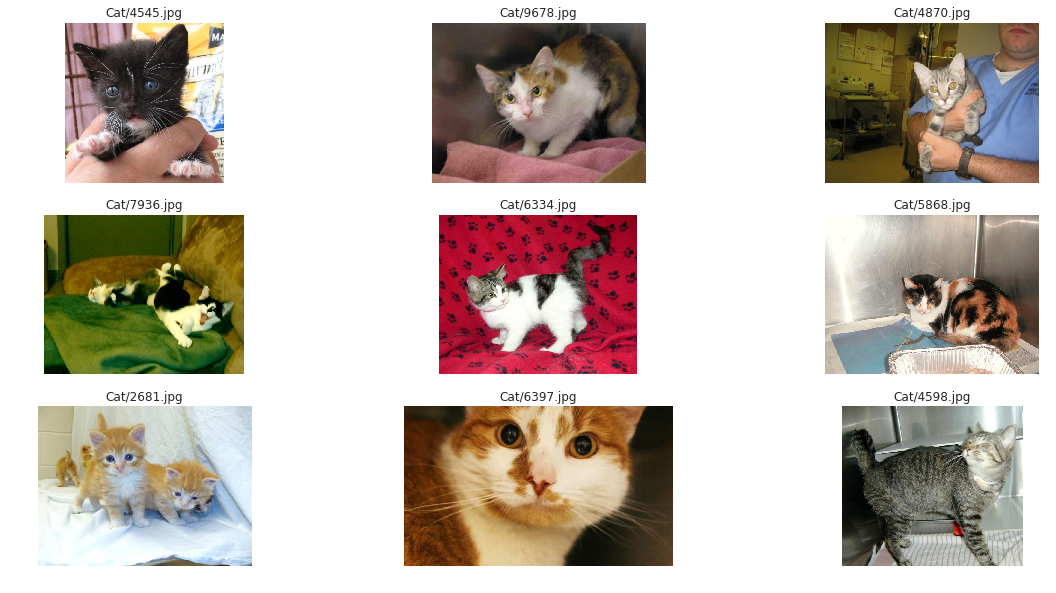

In [4]:
# Get list of file names (Cat images)
_, _, cat_images = next(os.walk('data/PetImages/Cat'))

# Prepare a 3x3 plot (total of 9 images)
fix, ax = plt.subplots(3, 3, figsize=(20, 10))

# Randomly select and plot an image
for idx, img in enumerate(random.sample(cat_images, 9)):
    img_read = plt.imread('data/PetImages/Cat/' + img)
    ax[int(idx / 3), idx % 3].imshow(img_read)
    ax[int(idx / 3), idx % 3].axis('off')
    ax[int(idx / 3), idx % 3].set_title('Cat/' + img)
plt.show()

## Insight:
# 1. The images have different dimensions.
# 2. The subjects (cat/dog) are mostly centered in the image.
# 3. The subjects (cat/dog) have different orientations, and they may be
# occluded in the image. In other words, there's no guarantee that we'll
# always see the tail of the cat in the image.

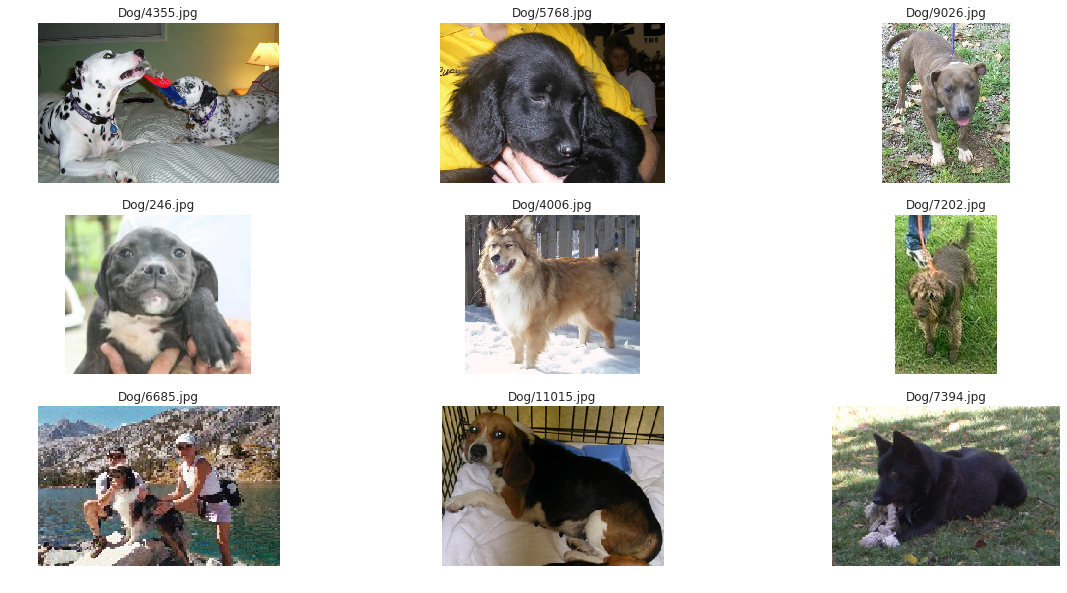

In [5]:
# Get list of file names (Dog images)
_, _, dog_images = next(os.walk('data/PetImages/Dog'))

# Prepare a 3x3 plot (total of 9 images)
fix, ax = plt.subplots(3, 3, figsize=(20, 10))

# Randomly select and plot an image
for idx, img in enumerate(random.sample(dog_images, 9)):
    img_read = plt.imread('data/PetImages/Dog/' + img)
    ax[int(idx / 3), idx % 3].imshow(img_read)
    ax[int(idx / 3), idx % 3].axis('off')
    ax[int(idx / 3), idx % 3].set_title('Dog/' + img)
plt.show()

# Note:
Above code don't show any output in vs code's jupyter notebook so please run the main.py using python to see the codes output.

```
$ python main.py
```

# Dataset Problem
Image classification is that most computers do not have sufficient RAM to load the entire set of data into memory. Even for relatively modern and powerful computers, it would be far too slow to load the entire set of images into memory and to train a CNN from there.

### Solution
Keras provides a useful flow_from_directory method that takes as an input the path to the images, and generates batches of data as output. The batches of data are loaded into memory, as required before model training. 

# Train Test Split of data - Helper Method

In [6]:
# Helper function to remove corrupt exif data from dataset
def remove_exif_data(src_folder):
    _, _, cat_images = next(os.walk(src_folder + 'Cat/'))

    for img in cat_images:
        try:
            piexif.remove(src_folder + 'Cat/' + img)
        except:
            pass

    _, _, dog_images = next(os.walk(src_folder + 'Dog/'))
    for img in dog_images:
        try:
            piexif.remove(src_folder + 'Dog/' + img)
        except:
            pass

In [7]:
def train_test_split(src_folder: str, train_size: float=0.8)-> None:
    # Make sure we wemove any existing folders and start from a clean slate
    shutil.rmtree(src_folder + 'Train/Cat/', ignore_errors=True)
    shutil.rmtree(src_folder + 'Train/Dog/', ignore_errors=True)
    shutil.rmtree(src_folder + 'Test/Cat/', ignore_errors=True)
    shutil.rmtree(src_folder + 'Test/Dog/', ignore_errors=True)

    # Now create new empty train and test folders
    os.makedirs(src_folder + 'Train/Cat/')
    os.makedirs(src_folder + 'Train/Dog/')
    os.makedirs(src_folder + 'Test/Cat/')
    os.makedirs(src_folder + 'Test/Dog/')

    # Get the number of cats and dogs images
    _, _, cat_images = next(os.walk(src_folder + 'Cat/'))
    files_to_be_removed = ['Thumbs.db', '11702.jpg']

    for file in files_to_be_removed:
        cat_images.remove(file)

    num_cat_images = len(cat_images)
    num_cat_images_train = int(train_size * num_cat_images)
    num_cat_images_test = num_cat_images - num_cat_images_train

    _, _, dog_images = next(os.walk(src_folder + 'Cat/'))
    files_to_be_removed = ['Thumbs.db', '666.jpg', '835.jpg']

    for file in files_to_be_removed:
        dog_images.remove(file)

    num_dog_images = len(dog_images)
    num_dog_images_train = int(train_size * num_dog_images)
    num_dog_images_test = num_dog_images - num_dog_images_train

    # Randomly assign images to train and test folder
    cat_train_images = random.sample(cat_images, num_cat_images_train)
    for img in cat_train_images:
        shutil.copy(src=src_folder + 'Cat/' + img, dst=src_folder + 'Train/Cat/')

    cat_test_images = [img for img in cat_images if img not in cat_train_images]
    for img in cat_test_images:
        shutil.copy(src=src_folder + 'Cat/' + img, dst=src_folder + 'Test/Cat/')

    dog_train_images = random.sample(dog_images, num_dog_images_train)
    for img in dog_train_images:
        shutil.copy(src=src_folder + 'Dog/' + img, dst=src_folder + 'Train/Dog/')

    dog_test_images = [img for img in dog_images if img not in dog_train_images]
    for img in dog_test_images:
        shutil.copy(src=src_folder + 'Dog/' + img, dst=src_folder + 'Test/Dog/')

    # Remove corrupted exif data from the dataset
    remove_exif_data(src_folder + 'Train/')
    remove_exif_data(src_folder + 'Test/')

In [19]:
BASE_DIR = os.getcwd() # Getting current working directories
src_folder = f'{BASE_DIR}/data/PetImages/'

In [13]:
train_test_split(src_folder)

# Exploratory data analysis

In [2]:
image_generator = ImageDataGenerator(rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest'
                                    )

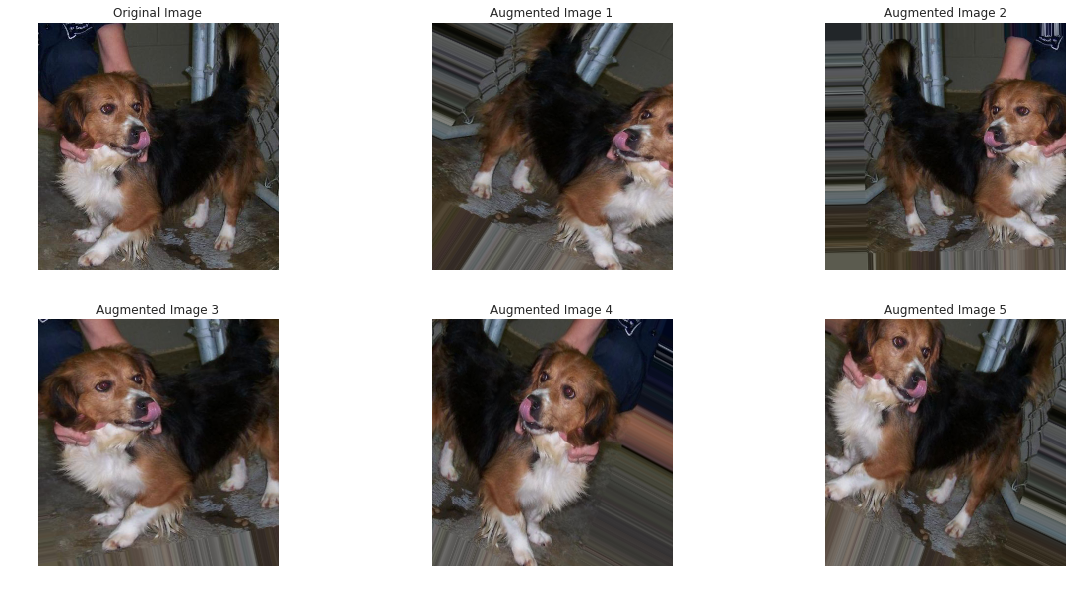

In [3]:
fix, ax = plt.subplots(2, 3, figsize=(20, 10))
all_images = []

# Train data path
BASE_DIR = os.getcwd()
train_folder_path = f'{BASE_DIR}/data/PetImages/Train/Dog/'
_, _, dog_images = next(os.walk(train_folder_path))
random_img = random.sample(dog_images, 1)[0]
random_img = plt.imread(f'{BASE_DIR}/data/PetImages/Train/Dog/' + random_img)
all_images.append(random_img)

random_img = random_img.reshape((1, ) + random_img.shape)
sample_augmented_images = image_generator.flow(random_img)

for _ in range(5):
    augmented_imgs = sample_augmented_images.next()
    for img in augmented_imgs:
        all_images.append(img.astype('uint8'))

for idx, img in enumerate(all_images):
    ax[int(idx / 3), idx % 3].imshow(img)
    ax[int(idx / 3), idx % 3].axis('off')
    if idx == 0:
        ax[int(idx / 3), idx % 3].set_title('Original Image')
    else:
        ax[int(idx / 3), idx % 3].set_title(f'Augmented Image {idx}')

plt.show()

# Model Selection

# Convolutional Neural Networks

In [ ]:
#### The Convolutional Neural Networks will have four hidden layers. The first 
# hidden layer will have 128 nodes, with each successive hidden layer 
# having half the nodes of its predecessor

# Activation function : ReLU(Rectified Linear Unit)

# Loss functions : RMSE (Root mean square error) ## The RMSE is a common loss function for regression tasks

# Output: regression problem, there will only be one node in the output layer ## Never use activation function on Output layer for Regreesion problem

# Model Building

![Simple CNN](images/simple_cnn.png)

#### The convolution and max pooling layers are responsible for learning the spatial characteristics of the classes (for example, identifying the ears of cats), whereas the Fully Connected layers learn to make predictions using these spatial characteristics

In [9]:
# Building a simple Convolutional Neural Networks
model = Sequential()

### Convolutional layer filter size: Most modern CNNs use a small filter
# size of 3 x 3.
### Number of filters: Let's use a filter number of 32. This is a good balance
# between speed and performance.
### Input size: As we've seen in an earlier section, the input images have
# different sizes, with their width and height approximately 150 px. Let's
# use an input size of 32 x 32 pixels. This compresses the original image,
# which can result in some information loss, but helps to speed up the
# training of our neural network.
### Max pooling size: A common max pooling size is 2 x 2. This will halve
# the input layer dimensions.
### Batch size: This corresponds to the number of training samples to use in
# each mini batch during gradient descent. A large batch size results in
# more accurate training but longer training time and memory usage. Let's
# use a batch size of 16.
### Steps per epoch: This is the number of iterations in each training epoch.
# Typically, this is equal to the number of training samples divided by the
# batch size
### Epochs: The number of epochs to train our data. Note that, in neural
# networks, the number of epochs refers to the number of times the model
# sees each training sample during training. Multiple epochs are usually
# needed, as gradient descent is an iterative optimization method. Let's
# train our model for 10 epochs. This means that each training sample will
# be passed to the the model 10 times during training.

In [10]:
# Hyperparameters
FILTER_SIZE = 3
NUM_FILTERS = 32
INPUT_SIZE = 32
MAXPOOL_SIZE = 2
BATCH_SIZE = 16
STEPS_PER_EPOCH = 20000 // BATCH_SIZE
EPOCHS = 10

In [12]:
# 1st Convulation & Max pooling layers
model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE),
                 input_shape=(INPUT_SIZE, INPUT_SIZE, 3),
                 activation='relu'
                ))

model.add(MaxPooling2D(pool_size=(MAXPOOL_SIZE, MAXPOOL_SIZE)))

In [13]:
# 2nd Convulation & Max pooling layers
model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE),
                 input_shape=(INPUT_SIZE, INPUT_SIZE, 3),
                 activation='relu'
                ))

model.add(MaxPooling2D(pool_size=(MAXPOOL_SIZE, MAXPOOL_SIZE)))

In [ ]:
## Note:
# Before we move on to the fully connected layers, we need to flatten its input. Flatten is a
# function in Keras that transforms a multidimensional vector into a single dimensional vector. 
# For example, if the vector is of shape (5,5,3) before passing to Flatten, the output vector 
# will be of shape (75) after passing to Flatten.

In [14]:
model.add(Flatten())

In [15]:
# Fully connected layer
model.add(Dense(units=128, activation='relu'))

In [ ]:
## Note 
# Before we add our last fully connected layer, it is a good practice to add a
# dropout layer. The dropout layer randomly sets a certain fraction of its input
# to 0. This helps to reduce overfitting, by ensuring that the model does not
# place too much emphasis on certain weights

In [16]:
# Set 50% of the weights to 0
model.add(Dropout(0.5))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.add(Dense(units=1, activation='sigmoid'))

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
training_data_generator = ImageDataGenerator(rescale=1./255)

training_set = training_data_generator.flow_from_directory(src_folder + 'Train/', target_size=(INPUT_SIZE, INPUT_SIZE),
                                                                                                batch_size=BATCH_SIZE,
                                                                                                class_mode='binary'
                                                          )
model.fit_generator(training_set, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=1)

Found 19994 images belonging to 2 classes.
Epoch 1/10
1250/1250 [==============================] - 236s 189ms/step - loss: 0.6074 - acc: 0.6703
Epoch 2/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.5152 - acc: 0.7475
Epoch 3/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.4651 - acc: 0.7790
Epoch 4/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.4322 - acc: 0.8036
Epoch 5/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.4060 - acc: 0.8132
Epoch 6/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.3856 - acc: 0.8250
Epoch 7/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.3576 - acc: 0.8405
Epoch 8/10
1250/1250 [==============================] - 66s 53ms/step - loss: 0.3358 - acc: 0.8525
Epoch 9/10
1250/1250 [==============================] - 66s 52ms/step - loss: 0.3076 - acc: 0.8651
Epoch 10/10
1250/1250 [==============================] - 65s 52m

In [23]:
# Test the model
testing_data_generator = ImageDataGenerator(rescale=1. / 255)

test_set = testing_data_generator.flow_from_directory(src_folder + 'Test/', target_size=(INPUT_SIZE, INPUT_SIZE),
                                                                                         batch_size=BATCH_SIZE,
                                                                                         class_mode='binary'
                                                     )

score = model.evaluate_generator(test_set, steps=len(test_set))
for idx, metric in enumerate(model.metrics_names):
    print(f'{metric}: {score[idx]}')

Found 5000 images belonging to 2 classes.
loss: 0.4679553797245026
acc: 0.7906


In [ ]:
# We obtained an accuracy of 79%

In [25]:
# Applying VGG16 CNN model
INPUT_SIZE = 128 # Change this to 48 if the code takes too long to run
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

# Freeze the layers
for layer in vgg16.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 106s 2us/step


In [27]:
input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model = Model(input=input_, output=last_layer)

In [28]:
# Define hyperparameters
BATCH_SIZE = 16
STEPS_PER_EPOCH = 200
EPOCHS = 3

In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
training_data_generator = ImageDataGenerator(rescale=1. / 255)
testing_data_generator = ImageDataGenerator(rescale=1. / 255)

In [31]:
training_set = training_data_generator.flow_from_directory(src_folder + 'Train/', target_size=(INPUT_SIZE, INPUT_SIZE),
                                                                                         batch_size=BATCH_SIZE,
                                                                                         class_mode='binary'
                                                     )

test_set = testing_data_generator.flow_from_directory(src_folder + 'Test/', target_size=(INPUT_SIZE, INPUT_SIZE),
                                                                                         batch_size=BATCH_SIZE,
                                                                                         class_mode='binary'
                                                     )

model.fit_generator(training_set, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=1)

Found 19994 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/3
200/200 [==============================] - 144s 719ms/step - loss: 0.3693 - acc: 0.8259
Epoch 2/3
200/200 [==============================] - 158s 789ms/step - loss: 0.2997 - acc: 0.8694
Epoch 3/3
200/200 [==============================] - 151s 754ms/step - loss: 0.2664 - acc: 0.8831


In [32]:
score = model.evaluate_generator(test_set, steps=len(test_set))
for idx, metric in enumerate(model.metrics_names):
    print(f'{metric}: {score[idx]}')

loss: 0.2814000208377838
acc: 0.8806


In [33]:
## Insight:
# By making use of transfer learning, we managed to obtain a testing accuracy of 88.06%

# Result Analysis